# EDA Final Project - Chicago Crime and COVID-19 rates 

## 11/28/2020

### Written by Elizabeth Beiler 

### History
* Read in CSV
* API
* Data Cleansing
* Merge CSVs into one new dataframe
* Statistics and outliers
* Boxplot
* Data Visuals
* Reporting

**Project Objective: Prove or disprove my hpothesis which states, as COVID-19 cases have risen in Chicago, crime rates have also risen.  Specifically crime types such as:**
1. Domestic Violence
2. Aggravated Assault
3. Theft 
4. Home Invasions
5. Gun Confiscations/Weapons
6. Murder
7. Shootings

Import necessary libraries 

In [3]:
##Begin all scripts by first importing all necessary libraries nedded for the script.
#System
import os
from os import listdir
from pathlib import Path 
import itertools
import collections

# Analytics
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import datetime as dt
from datetime import timedelta
import statsmodels.api as sm
import re

#Visuals 
import seaborn as sns 
import plotly as py
import plotly.express as px
import matplotlib.pyplot as plt

#Pulling Data
import requests
import json
from sodapy import Socrata


## Defining Function to pull datasets

In [31]:
# Set up SODAPI
# SODAPI doumentation 
# https://pypi.org/project/sodapy/
def download_dataset(domain, dataset_id, where):
    # for this exercise, we're not using an app token
    client = Socrata(domain, app_token=None)
    offset = 0
    data = []
    batch_size = 100000
    
    while True:
        records = client.get(dataset_id, offset=offset, limit=batch_size, where=where)
        data += records
        if len(records) < batch_size:
            break
        offset += batch_size
    return pd.DataFrame.from_records(data)

## Pulling Crime data

In [32]:
def download_crime_dataset(pull_new=False): # Defaults not to pull a new dataset
    file = "chi_crime_data.csv"
    if pull_new or (file not in os.listdir()) :
        dataset = download_dataset("Data.cityofchicago.org", "ijzp-q8t2","year >= 2018")
        dataset.to_csv(file)
        return dataset
    else: 
        return pd.read_csv(file)

In [39]:
crime_df = download_crime_dataset()

## Pulling COVID data

In [34]:
def download_covid_dataset(pull_new=False):
    file = "chi_covid_data.csv"
    if pull_new or (file not in os.listdir()) :
        dataset = download_dataset("Data.cityofchicago.org", "naz8-j4nc",None)
        dataset.to_csv(file)
        return dataset
    else: 
        return pd.read_csv(file)  

In [35]:
covid_df = download_covid_dataset()

In [40]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715786 entries, 0 to 715785
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            715786 non-null  int64  
 1   id                    715786 non-null  int64  
 2   case_number           715786 non-null  object 
 3   date                  715786 non-null  object 
 4   block                 715786 non-null  object 
 5   iucr                  715786 non-null  object 
 6   primary_type          715786 non-null  object 
 7   description           715786 non-null  object 
 8   location_description  712680 non-null  object 
 9   arrest                715786 non-null  bool   
 10  domestic              715786 non-null  bool   
 11  beat                  715786 non-null  int64  
 12  district              715786 non-null  int64  
 13  ward                  715759 non-null  float64
 14  community_area        715786 non-null  int64  
 15  

## Cleanse the data 

In [36]:
#Get a count of the N/As in the COVID dataframe 
covid_count = covid_df.isna().sum()
covid_count

lab_report_date                            1
cases_total                                0
deaths_total                               0
hospitalizations_total                     5
cases_age_0_17                             0
cases_age_18_29                            0
cases_age_30_39                            0
cases_age_40_49                            0
cases_age_50_59                            0
cases_age_60_69                            0
cases_age_70_79                            0
cases_age_80_                              0
cases_age_unknown                          0
cases_female                               0
cases_male                                 0
cases_unknown_gender                       0
cases_latinx                               0
cases_asian_non_latinx                     0
cases_black_non_latinx                     0
cases_white_non_latinx                     0
cases_other_non_latinx                     0
cases_unknown_race_eth                     0
deaths_0_1

In [38]:
##Drop the N/As from the columns in the COVID dataframe
covid_df = covid_df.dropna()
covid_df.isna().sum()

lab_report_date                            0
cases_total                                0
deaths_total                               0
hospitalizations_total                     0
cases_age_0_17                             0
cases_age_18_29                            0
cases_age_30_39                            0
cases_age_40_49                            0
cases_age_50_59                            0
cases_age_60_69                            0
cases_age_70_79                            0
cases_age_80_                              0
cases_age_unknown                          0
cases_female                               0
cases_male                                 0
cases_unknown_gender                       0
cases_latinx                               0
cases_asian_non_latinx                     0
cases_black_non_latinx                     0
cases_white_non_latinx                     0
cases_other_non_latinx                     0
cases_unknown_race_eth                     0
deaths_0_1

In [290]:
##Check for null values in the COVID dataframe
covid_df.isnull().sum()

Date                                         0
Cases - Total                                0
Deaths - Total                               0
Hospitalizations - Total                     0
Cases - Age 0-17                             0
Cases - Age 18-29                            0
Cases - Age 30-39                            0
Cases - Age 40-49                            0
Cases - Age 50-59                            0
Cases - Age 60-69                            0
Cases - Age 70-79                            0
Cases -  Age 80+                             0
Cases - Age Unknown                          0
Cases - Female                               0
Cases - Male                                 0
Cases - Unknown Gender                       0
Cases - Latinx                               0
Cases - Asian Non-Latinx                     0
Cases - Black Non-Latinx                     0
Cases - White Non-Latinx                     0
Cases - Other Race Non-Latinx                0
Cases - Unkno

In [41]:
##Do the same N/A and null cleanup for the Crime dataframe
crime_df.isna().sum()

Unnamed: 0                  0
id                          0
case_number                 0
date                        0
block                       0
iucr                        0
primary_type                0
description                 0
location_description     3106
arrest                      0
domestic                    0
beat                        0
district                    0
ward                       27
community_area              0
fbi_code                    0
x_coordinate            29100
y_coordinate            29100
year                        0
updated_on                  0
latitude                29100
longitude               29100
location                29100
dtype: int64

In [42]:
##Drop the N/As from the columns in the Crime dataframe
crime_df = crime_df.dropna()
crime_df.isna().sum()

Unnamed: 0              0
id                      0
case_number             0
date                    0
block                   0
iucr                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
ward                    0
community_area          0
fbi_code                0
x_coordinate            0
y_coordinate            0
year                    0
updated_on              0
latitude                0
longitude               0
location                0
dtype: int64

In [43]:
crime_df.isnull().sum()

Unnamed: 0              0
id                      0
case_number             0
date                    0
block                   0
iucr                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
ward                    0
community_area          0
fbi_code                0
x_coordinate            0
y_coordinate            0
year                    0
updated_on              0
latitude                0
longitude               0
location                0
dtype: int64

In [44]:
##Check for duplicates in COVID dataframe
covid_df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
269    False
270    False
271    False
272    False
273    False
Length: 268, dtype: bool

In [49]:
##Drop columns with unknown and other not needed in dfcovid that I missed
cols = ["deaths_unknown_gender", "deaths_unknown_age", "cases_unknown_race_eth", "cases_age_unknown"]
covid_df.drop(columns=cols, inplace=True)

In [51]:
## dropping columns for crime
cols = ["ward", "block", "updated_on", "community_area", "location_description", "case_number", "beat", "id", "location", "longitude", "x_coordinate", "y_coordinate", "latitude"]
unnamed = [col for col in crime_df.columns if col.startswith('Unamed')]
cols = cols.append(unnamed)
crime_df.drop(columns=cols,inplace=True)

In [57]:
##Change data type for year from object to string 
crime_df['year'] = crime_df['year'].astype(str)

In [58]:
##Check the value counts for 2018, 2019, 2020
crime_df["year"].value_counts()

2018    262798
2019    258156
2020    163351
Name: year, dtype: int64

In [59]:
##Change the data formats for crime dataframe
crime_df['date'] = pd.to_datetime(crime_df['date']).dt.date

In [60]:
crime_df.head(2)

,Unnamed: 0,date,iucr,primary_type,description,arrest,domestic,district,fbi_code,year
0,0,2018-08-20,1752,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,False,True,14,17,2018
1,1,2018-10-14,031A,ROBBERY,ARMED - HANDGUN,True,False,18,03,2018


In [61]:
covid_df.head(2)

,lab_report_date,cases_total,deaths_total,hospitalizations_total,cases_age_0_17,cases_age_18_29,cases_age_30_39,cases_age_40_49,cases_age_50_59,cases_age_60_69,...,hospitalizations_age_unknown,hospitalizations_female,hospitalizations_male,hospitalizations_unknown_gender,hospitalizations_latinx,hospitalizations_asian_non_latinx,hospitalizations_black_non_latinx,hospitalizations_white_non_latinx,hospitalizations_other_race_non_latinx,hospitalizations_unknown_race_ethnicity
0,2020-03-29T00:00:00.000,282,20,130,4,29,48,54,50,50,...,0,57,73,0,21,3,92,11,2,1
1,2020-03-01T00:00:00.000,0,0,2,0,0,0,0,0,0,...,0,1,1,0,0,0,0,2,0,0


In [62]:
##Change the data formats for covid 
covid_df['lab_report_date'] = pd.to_datetime(covid_df['lab_report_date']).dt.date

In [63]:
covid_df.head(2)

,lab_report_date,cases_total,deaths_total,hospitalizations_total,cases_age_0_17,cases_age_18_29,cases_age_30_39,cases_age_40_49,cases_age_50_59,cases_age_60_69,...,hospitalizations_age_unknown,hospitalizations_female,hospitalizations_male,hospitalizations_unknown_gender,hospitalizations_latinx,hospitalizations_asian_non_latinx,hospitalizations_black_non_latinx,hospitalizations_white_non_latinx,hospitalizations_other_race_non_latinx,hospitalizations_unknown_race_ethnicity
0,2020-03-29,282,20,130,4,29,48,54,50,50,...,0,57,73,0,21,3,92,11,2,1
1,2020-03-01,0,0,2,0,0,0,0,0,0,...,0,1,1,0,0,0,0,2,0,0


Merge the dataframes 

In [128]:
# Searching by a specific date
crime_df.loc[crime_df['date']==dt.date(year=2018,month=1,day=1)]['primary_type'].value_counts()

BATTERY                             158
THEFT                               128
OFFENSE INVOLVING CHILDREN           84
DECEPTIVE PRACTICE                   69
MOTOR VEHICLE THEFT                  65
CRIMINAL DAMAGE                      65
OTHER OFFENSE                        60
ASSAULT                              38
BURGLARY                             32
ROBBERY                              30
SEX OFFENSE                          25
WEAPONS VIOLATION                    20
NARCOTICS                            17
CRIM SEXUAL ASSAULT                  13
CRIMINAL TRESPASS                     9
HOMICIDE                              4
CRIMINAL SEXUAL ASSAULT               2
INTERFERENCE WITH PUBLIC OFFICER      2
PUBLIC PEACE VIOLATION                2
INTIMIDATION                          1
LIQUOR LAW VIOLATION                  1
STALKING                              1
Name: primary_type, dtype: int64

In [118]:
crime_df['count'] = 1
prim_count_pivot = crime_df.pivot_table(values='count',index='date',columns='primary_type',aggfunc={'count':np.sum}) # Creating a pivot table based on primary type count per day
prim_count_pivot.fillna(0, inplace=True) #Inserting 0 for blanks
prim_count_pivot['total'] = prim_count_pivot.sum(axis=1,skipna=True)

In [119]:
prim_count_pivot

primary_type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,total
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.0,38.0,158.0,32.0,0.0,13.0,65.0,2.0,9.0,69.0,...,60.0,0.0,0.0,2.0,30.0,25.0,1.0,128.0,20.0,826.0
2018-01-02,0.0,28.0,89.0,20.0,0.0,2.0,46.0,0.0,17.0,53.0,...,49.0,0.0,0.0,3.0,28.0,0.0,0.0,123.0,9.0,546.0
2018-01-03,1.0,39.0,81.0,19.0,0.0,3.0,38.0,0.0,17.0,45.0,...,38.0,3.0,0.0,3.0,37.0,0.0,0.0,154.0,12.0,558.0
2018-01-04,2.0,42.0,102.0,31.0,0.0,0.0,47.0,0.0,23.0,42.0,...,43.0,0.0,0.0,2.0,32.0,0.0,1.0,133.0,15.0,595.0
2018-01-05,0.0,53.0,107.0,24.0,0.0,3.0,63.0,1.0,16.0,56.0,...,44.0,0.0,0.0,1.0,34.0,2.0,0.0,164.0,9.0,660.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2020-11-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2020-11-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [132]:
result = pd.merge(covid_df,prim_count_pivot,left_on='lab_report_date',right_on=prim_count_pivot.index,how='inner')
result.sort_values('lab_report_date',inplace=True)
result.reset_index(inplace=True,drop=True)

In [133]:
result.head()

,lab_report_date,cases_total,deaths_total,hospitalizations_total,cases_age_0_17,cases_age_18_29,cases_age_30_39,cases_age_40_49,cases_age_50_59,cases_age_60_69,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,total
0,2020-03-01,0,0,2,0,0,0,0,0,0,...,53.0,0.0,0.0,4.0,17.0,7.0,2.0,129.0,21.0,695.0
1,2020-03-02,0,0,2,0,0,0,0,0,0,...,43.0,0.0,0.0,4.0,15.0,2.0,0.0,135.0,19.0,577.0
2,2020-03-03,0,0,3,0,0,0,0,0,0,...,39.0,0.0,0.0,0.0,7.0,1.0,0.0,151.0,20.0,622.0
3,2020-03-04,0,0,4,0,0,0,0,0,0,...,51.0,1.0,0.0,2.0,23.0,3.0,1.0,140.0,6.0,610.0
4,2020-03-05,1,0,6,0,0,0,0,1,0,...,42.0,6.0,0.0,5.0,11.0,3.0,0.0,137.0,13.0,574.0


Statsistics and Outliers

In [134]:
result.describe()

,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,total
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.0,258.000000,258.000000,258.000000,258.000000,...,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000
mean,1.589147,46.007752,104.046512,22.426357,0.348837,0.0,63.961240,2.558140,8.996124,26.736434,...,27.895349,0.779070,0.019380,3.639535,18.333333,2.089147,0.445736,92.321705,21.205426,488.631783
std,2.470408,19.770668,44.500926,42.472472,0.619416,0.0,32.483555,1.924274,4.925514,13.601625,...,12.501856,2.349275,0.138124,19.589511,9.845763,1.745422,0.693887,38.557264,12.475051,212.936373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,39.000000,92.250000,15.000000,0.000000,0.0,57.000000,1.000000,6.000000,20.000000,...,23.000000,0.000000,0.000000,1.000000,14.000000,1.000000,0.000000,82.250000,14.000000,436.250000
50%,1.000000,50.000000,111.000000,19.000000,0.000000,0.0,67.000000,2.000000,9.000000,28.500000,...,30.000000,0.000000,0.000000,2.000000,19.000000,2.000000,0.000000,99.000000,20.000000,545.500000
75%,2.000000,59.000000,130.000000,24.000000,1.000000,0.0,78.000000,4.000000,12.000000,35.000000,...,36.000000,0.000000,0.000000,3.000000,24.000000,3.000000,1.000000,116.000000,28.000000,605.000000
max,28.000000,81.000000,186.000000,580.000000,3.000000,0.0,341.000000,11.000000,25.000000,60.000000,...,54.000000,15.000000,1.000000,308.000000,81.000000,11.000000,4.000000,154.000000,62.000000,1890.000000


In [145]:
result["cases_total"] = result["cases_total"].astype(float)

In [147]:
X = result["cases_total"]
y = result['total']
X = sm.add_constant(X)

model = sm.OLS(y,X).fit()
pred = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     299.7
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           5.61e-45
Time:                        21:34:16   Log-Likelihood:                -1648.7
No. Observations:                 258   AIC:                             3301.
Df Residuals:                     256   BIC:                             3309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         635.2004     12.368     51.358      0.000     610.844     659.557
cases_total    -0.2687      0.016    -17.311      0.000      -0.299      -0.238
==============================================================================
Omnibus:                      168.278   Durbin-Watson:                   0.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6966.972
Skew:                           1.930   Prob(JB):                         0.00
Kurtosis:                      28.163   Cond. No.                     1.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [321]:
##Adding in statistical hypothesis testing component

In [170]:
result.columns

Index(['lab_report_date', 'cases_total', 'deaths_total',
       'hospitalizations_total', 'cases_age_0_17', 'cases_age_18_29',
       'cases_age_30_39', 'cases_age_40_49', 'cases_age_50_59',
       'cases_age_60_69', 'cases_age_70_79', 'cases_age_80_', 'cases_female',
       'cases_male', 'cases_unknown_gender', 'cases_latinx',
       'cases_asian_non_latinx', 'cases_black_non_latinx',
       'cases_white_non_latinx', 'cases_other_non_latinx', 'deaths_0_17_yrs',
       'deaths_18_29_yrs', 'deaths_30_39_yrs', 'deaths_40_49_yrs',
       'deaths_50_59_yrs', 'deaths_60_69_yrs', 'deaths_70_79_yrs',
       'deaths_80_yrs', 'deaths_female', 'deaths_male', 'deaths_latinx',
       'deaths_asian_non_latinx', 'deaths_black_non_latinx',
       'deaths_white_non_latinx', 'deaths_other_non_latinx',
       'deaths_unknown_race_eth', 'hospitalizations_age_0_17',
       'hospitalizations_age_18_29', 'hospitalizations_age_30_39',
       'hospitalizations_age_40_49', 'hospitalizations_age_50_59',
       

In [175]:
result['deaths_total'] =result['deaths_total'].astype(float)

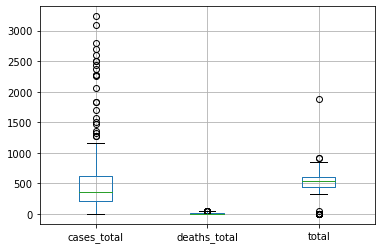

In [177]:
##Adding boxplot for total cases of covid 
cols = [col for col in result.columns if col.startswith('cases')]
result.boxplot(column = ['cases_total','deaths_total','total'])

Data Visualization 

In [163]:
prim_count_totals = prim_count_pivot.sum(axis=0).to_frame(name='count')
prim_count_totals.drop(index='total',inplace=True)
prim_count_totals.sort_values('count',ascending=False,inplace=True)
prim_count_totals

,count
primary_type,
THEFT,158121.0
BATTERY,133026.0
CRIMINAL DAMAGE,74334.0
ASSAULT,55696.0
DECEPTIVE PRACTICE,43963.0
OTHER OFFENSE,43530.0
NARCOTICS,33353.0
BURGLARY,28461.0
MOTOR VEHICLE THEFT,26373.0


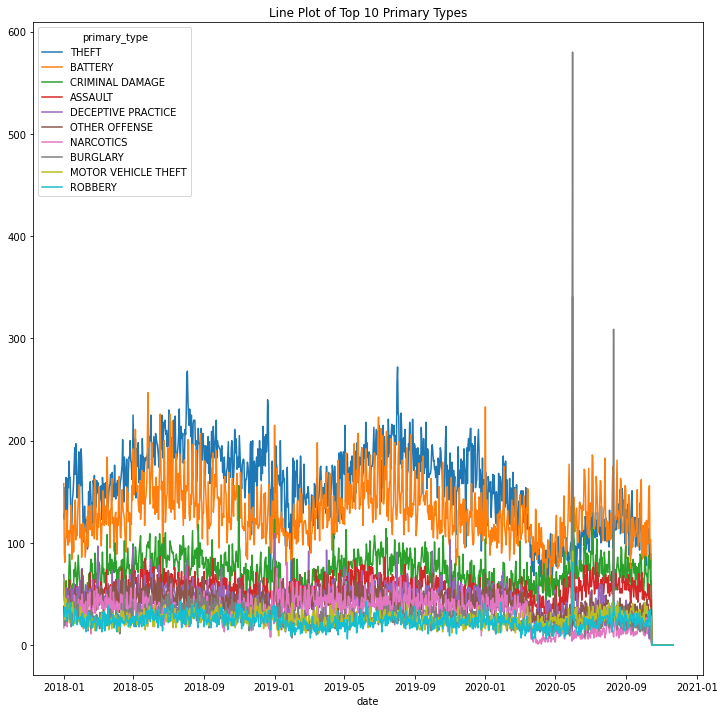

In [168]:
prim_count_top10 = prim_count_totals[:10].index
axes = prim_count_pivot[prim_count_top10].plot.line(figsize=(12,12),title='Line Plot of Top 10 Primary Types')